## 建立问题和设定目标

首先这是一个数据分析的练习项目，我选择了泰坦尼克船客的数据进行分析，试图回答和预测：
 - 是什么因素导致高概率的存活？是否和性别，年龄，船舱级别或者其他任何因素有关？
 - 是否可以预测任何一个船客的存活概率？最好可以和实际结果进行对照。


## 数据加工（数据获取和清洗）

- 数据概览
本案例分析的所有数据来自[Kaggle 网站](https://www.kaggle.com/c/titanic/data), 该网站对数据的说明如下：

    Variable	Definition	Key
    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#use read_csv() to get all data
file_name = 'gender_submission.csv'
gender_submission = pd.read_csv(file_name)

print gender_submission.info()
print gender_submission.head()
print gender_submission.groupby(['Survived']).size()
total_no_survived_num = gender_submission.groupby(['Survived']).size()[0]
total_survived_num = gender_submission.groupby(['Survived']).size()[1]

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data colu

从上面的信息看，总共有891个记录，或者说有891个乘客。另外发现Age数据不全，总共才714个记录，另外Cabin和Embarked数据也不全，我们需要想办法补充这部分数据。

另外发现这891个乘客到底只有342人生还，549人丧生，整体存活率是38%，死亡率是62%，具体哪些因素和死亡率有关，我们需要一步步来进行数据分析。

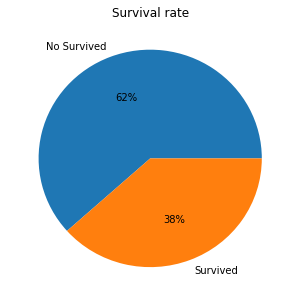

In [74]:
plt.figure(figsize = (5,5))
plt.pie([total_no_survived_num, total_survived_num],labels=['No Survived','Survived'],autopct='%1.00f%%')
plt.title('Survival rate') 

plt.show()


- 数据的清洗和补充

经常原始数据需要重新加工材可以获得更有价值的信息。
比如从年龄的数据看，一方面0.42岁到80岁不等，按照这个划分太细，得不出什么结论，另外一方面数据不够完整，只有714条记录，因此我们可以采用随机数来补充数据。

1）将年龄划分几个部分：
0～12岁：儿童；
13～20岁：青少年，基本上未婚；
21～40岁，青年，可能已经有孩子，具有责任感；
41岁到59岁：中年，可能上有老，下有小；
60岁到80岁：老年，可能有孙子了，可能老伴已经离开了。

2）按照以上划分求出不同年龄段的比例，假定人员年龄丢失的信息是按照这个比例，但是也有可能不是按照这个比例，由于丢失年龄的记录是891-714=177，比例在20%不到，上不改变最终年龄的均值，但是会降低每个年龄段的存活率，因为增加了分母，然后按照这个比例去找随机数，补充进来。

在开始之前，我们先删除原始数据中没有用的信息，比如PassengerId, Name, Ticket

In [168]:
## 删除没有用的信息，排除他们的干扰
titanic_clean_df = gender_submission.drop(['PassengerId','Name','Ticket'], axis=1)
total_age_count = titanic_clean_df['Age'].count()
total_age_missed = titanic_clean_df['Survived'].count()-total_age_count

print "有年龄纪录的数目是%d, 丢失了%d" %(total_age_count,total_age_missed)

## 按照上面的划分对数据进行初步加工,每个年龄阶段的所占比例，总数
def change_age_category(age):
    if age<=12:
        return 'Child'
    elif (age <= 20 and age > 12):
        return 'Juvenile'
    elif (age <= 40 and age > 20):
        return 'Adult'
    elif (age <= 60 and age > 40):
        return 'Middle'
    else:
        return 'Senior'

age_data =  titanic_clean_df['Age'].apply(change_age_category)
titanic_clean_df['Age_level'] = age_data

print titanic_clean_df.groupby(['Age_level']).size()

def add_random_to_missed():
    


'''
children_df = titanic_clean_df[ titanic_clean_df['Age'] <= 12]
juvenile_df = titanic_clean_df[(titanic_clean_df['Age'] > 12) & (titanic_clean_df['Age'] <= 20)]
adults_df = titanic_clean_df[(titanic_clean_df['Age'] >20) & (titanic_clean_df['Age'] <=40)]
middle_df = titanic_clean_df[(titanic_clean_df['Age'] >40) & (titanic_clean_df['Age'] <=60)]
senior_df = titanic_clean_df[titanic_clean_df['Age'] > 60]

## 各年龄段总人数,占总体人群比例，生还人数，生还率
children_survived_grouped = children_df.groupby(['Survived'])
juvenile_survived_grouped = juvenile_df.groupby(['Survived'])
adults_survived_grouped = adults_df.groupby(['Survived'])
middle_survived_grouped = middle_df.groupby(['Survived'])
senior_survived_grouped = senior_df.groupby(['Survived'])

children_count = sum(children_survived_grouped.size())
juvenile_count = sum(juvenile_survived_grouped.size())
adults_count = sum(adults_survived_grouped.size())
middle_count = sum(middle_survived_grouped.size())
senior_count = sum(senior_survived_grouped.size())
##计算各个年龄段增补数目
children_missed_num = (float(children_count)/total_age_count)*total_age_missed
'''


有年龄纪录的数目是714, 丢失了177
Age_level
Adult       385
Child        69
Juvenile    110
Middle      128
Senior      199
dtype: int64
69


"\nchildren_df = titanic_clean_df[ titanic_clean_df['Age'] <= 12]\njuvenile_df = titanic_clean_df[(titanic_clean_df['Age'] > 12) & (titanic_clean_df['Age'] <= 20)]\nadults_df = titanic_clean_df[(titanic_clean_df['Age'] >20) & (titanic_clean_df['Age'] <=40)]\nmiddle_df = titanic_clean_df[(titanic_clean_df['Age'] >40) & (titanic_clean_df['Age'] <=60)]\nsenior_df = titanic_clean_df[titanic_clean_df['Age'] > 60]\n\n## \xe5\x90\x84\xe5\xb9\xb4\xe9\xbe\x84\xe6\xae\xb5\xe6\x80\xbb\xe4\xba\xba\xe6\x95\xb0,\xe5\x8d\xa0\xe6\x80\xbb\xe4\xbd\x93\xe4\xba\xba\xe7\xbe\xa4\xe6\xaf\x94\xe4\xbe\x8b\xef\xbc\x8c\xe7\x94\x9f\xe8\xbf\x98\xe4\xba\xba\xe6\x95\xb0\xef\xbc\x8c\xe7\x94\x9f\xe8\xbf\x98\xe7\x8e\x87\nchildren_survived_grouped = children_df.groupby(['Survived'])\njuvenile_survived_grouped = juvenile_df.groupby(['Survived'])\nadults_survived_grouped = adults_df.groupby(['Survived'])\nmiddle_survived_grouped = middle_df.groupby(['Survived'])\nsenior_survived_grouped = senior_df.groupby(['Survived'])\n

In [97]:

# 各年龄段总人数,占总体人群比例，生还人数，生还率
children_survived_grouped = children_df.groupby(['Survived'])
juvenile_survived_grouped = juvenile_df.groupby(['Survived'])
adults_survived_grouped = adults_df.groupby(['Survived'])
middle_survived_grouped = middle_df.groupby(['Survived'])
senior_survived_grouped = senior_df.groupby(['Survived'])

#
total_age_count = 714
age_mean = titanic_clean_df['Age'].mean()
children_count = sum(children_survived_grouped.size())
juvenile_count = sum(juvenile_survived_grouped.size())
adults_count = sum(adults_survived_grouped.size())
middle_count = sum(middle_survived_grouped.size())
senior_count = sum(senior_survived_grouped.size())
children_survived = children_survived_grouped.size()[1]
juvenile_survived = juvenile_survived_grouped.size()[1]
adults_survived = adults_survived_grouped.size()[1]
middle_survived = middle_survived_grouped.size()[1]
senior_survived = senior_survived_grouped.size()[1]

#children的总数，比例，生还人数，比例
children_rate = float(children_count)/total_age_count
children_survived_rate = float(children_survived)/children_count
print children_count, children_rate, children_survived, children_survived_rate

#juvenile的总数，比例，生还人数，比例
juvenile_rate = float(juvenile_count)/total_age_count
juvenile_survived_rate = float(juvenile_survived)/juvenile_count
print juvenile_count, juvenile_rate, juvenile_survived, juvenile_survived_rate

#adults的总数，比例，生还人数，比例
adults_rate = float(adults_count)/total_age_count
adults_survived_rate = float(adults_survived)/adults_count
print adults_count, adults_rate, adults_survived, adults_survived_rate

#adults的总数，比例，生还人数，比例
middle_rate = float(middle_count)/total_age_count
middle_survived_rate = float(middle_survived)/middle_count
print middle_count, middle_rate, middle_survived, middle_survived_rate

#adults的总数，比例，生还人数，比例
senior_rate = float(middle_count)/total_age_count
senior_survived_rate = float(senior_survived)/middle_count
print senior_count, senior_rate, senior_survived, senior_survived_rate



69 0.0966386554622 40 0.579710144928
110 0.15406162465 42 0.381818181818
385 0.539215686275 153 0.397402597403
128 0.179271708683 50 0.390625
22 0.179271708683 5 0.0390625


In [42]:
def correlation(x, y):
    '''
    Each input is either a NumPy array or a Pandas
    Series.
    correlation = average of (x in standard units) times (y in standard units)
    Remember to pass the argument "ddof=0" to the Pandas std() function!
    '''

    x_normalize = (x-x.mean())/x.std(ddof=0)
    y_normalize = (y-y.mean())/y.std(ddof=0)
    
    return (x_normalize*y_normalize).mean()

## 由于性别里面存储的是字符，我们先把该列变成数字，可以采用apply()
## 假定male是1，female是-1，其他为0
def change_sex_to_digit(sex):
    if sex =='male':
        return 1
    elif sex == 'female':
        return -1
    else:
        return 0

## 将年龄归一化，画一个散点图看看。
def standardize_col(column_array):
    '''
    注意，计算得出的默认标准偏差类型在 numpy 的 .std() 和 pandas 的 .std() 函数之间是不同的。
    默认情况下，numpy 计算的是总体标准偏差，ddof = 0。另一方面，pandas 计算的是样本标准偏差，ddof = 1。
    如果我们知道所有的分数，那么我们就有了总体——因此，要使用 pandas 进行归一化处理，我们需要将“ddof”设置为 0。
    '''
    return (column_array-column_array.mean())/column_array.std(ddof = 0)


new_gender = gender_submission['Sex'].apply(change_sex_to_digit) 
#new_age_data = standardize_col(gender_submission['Age'])

#print new_age_data.describe()

print correlation(gender_submission['Survived'],gender_submission['Age'])
print correlation(gender_submission['Survived'],gender_submission['Pclass'])

-0.0779826784139
-0.338481035961


### 2. 从上面的相关性来看，是否幸存和船舱等级有一定相关性，我们再继续加工一下数据，探索一下

In [60]:
grouped_by_sex = gender_submission.groupby(['Survived','Sex'])
grouped_by_pclass = gender_submission.groupby(['Survived','Pclass'])
grouped_by_sibSp = gender_submission.groupby(['Survived','SibSp'])
grouped_by_age = gender_submission.groupby(['Age'])

#print grouped_by_sex.describe()
#print grouped_by_pclass.describe()
#print grouped_by_sibSp.describe()
total_dead_people = gender_submission.groupby(['Survived']).size()[0]
total_live_people = gender_submission.groupby(['Survived']).size()[1]

print total_dead_people, total_live_people


print grouped_by_sex.mean()
print grouped_by_sex.size()
print '\n'

#def normalize(value):
  
print grouped_by_pclass.size()
print '\n'

print grouped_by_sibSp.size()
print '\n'

#print grouped_by_age.size()
#plt.show()


549 342
                 PassengerId    Pclass        Age     SibSp     Parch  \
Survived Sex                                                            
0        female   434.851852  2.851852  25.046875  1.209877  1.037037   
         male     449.121795  2.476496  31.618056  0.440171  0.207265   
1        female   429.699571  1.918455  28.847716  0.515021  0.515021   
         male     475.724771  2.018349  27.276022  0.385321  0.357798   

                      Fare  
Survived Sex                
0        female  23.024385  
         male    21.960993  
1        female  51.938573  
         male    40.821484  
Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64


Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
dtype: int64


Survived  SibSp
0         0        398
          1         97
          2  

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(grouped_by_survived['Age'],grouped_by_survived['Age'])
plt.show()

ValueError: setting an array element with a sequence.